Gold Price Prediction
---

**Modelo de regresión multivariable con componentes temporales**

## Conexion Drive

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')

## Librerias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

pd.set_option('display.max_columns', None)

## **Funciones**

In [3]:
# -----------------------------
# Funciones de interpretación
# -----------------------------

# 1. Interpretación del Coeficiente de Variación (CV)
def interpret_cv(cv):
    if cv < 0.1:
        return "Muy baja dispersión, media muy representativa"
    elif cv < 0.3:
        return "Baja dispersión, media representativa"
    elif cv < 0.6:
        return "Dispersión moderada, media algo representativa"
    else:
        return "Alta dispersión, media poco representativa"

# 2. Interpretación de la Curtosis
def interpret_kurtosis(k):
    if k > 3:
        return "Distribución con picos altos y valores extremos frecuentes"
    elif k < 3:
        return "Distribución más plana, sin picos marcados ni extremos"
    else:
        return "Distribución similar a la normal, picos y extremos moderados"

# 3. Interpretación de la Asimetría
def interpret_skew(sk):
    if sk > 1:
        return "Sesgo positivo fuerte (cola derecha)"
    elif sk > 0.5:
        return "Sesgo positivo moderado (derecha)"
    elif sk > -0.5:
        return "Casi simétrica"
    elif sk > -1:
        return "Sesgo negativo moderado (izquierda)"
    else:
        return "Sesgo negativo fuerte (cola izquierda)"

# 4. Interpretación del rango intercuartílico
def interpret_iqr(row):
    iqr = row['75%'] - row['25%']
    mean_val = row['mean']

    if iqr == 0:
        return "No hay dispersión entre los valores centrales"
    elif iqr < mean_val*0.25:
        return "Poca dispersión entre los valores centrales"
    elif iqr < mean_val*0.5:
        return "Dispersión moderada entre los valores centrales"
    else:
        return "Dispersión alta entre los valores centrales"

# 5. Detectar variables dicotómicas
def is_binary(row):
    # Se asume que min y max son 0 y 1
    if row['min'] == 0 and row['max'] == 1:
        return True
    # Opcional: si tiene pocos valores diferentes respecto al count
    return False

In [4]:
# Función para detectar outliers según regla IQR
def detectar_outliers_serie(serie):
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return (serie < lim_inf) | (serie > lim_sup)

## Variables

In [6]:
path = '/gdrive/MyDrive/Data_Science_Workspace/1. Data_Collection_and_Preprocessing/Raw_Datasets/gld_price_data.csv'
path = 'data/gld_price_data.csv'

# **I. Lectura Datos**

In [7]:
df_prev = pd.read_csv(path)

In [8]:
df_prev["Date"] = pd.to_datetime(df_prev["Date"], format="%m/%d/%Y")

df_prev["year"] = df_prev["Date"].dt.year
df_prev["month"] = df_prev["Date"].dt.month
df_prev["day"] = df_prev["Date"].dt.day
df_prev["dayofyear"] = df_prev["Date"].dt.dayofyear
df_prev["week"] = df_prev["Date"].dt.isocalendar().week

In [9]:
# Vista data
print(df_prev.shape)
display(df_prev.head())
display(df_prev.tail())

(2290, 11)


,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692,2008,1,2,2,1
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491,2008,1,3,3,1
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492,2008,1,4,4,1
3,2008-01-07,1416.180054,84.769997,75.500000,15.053,1.468299,2008,1,7,7,2
4,2008-01-08,1390.189941,86.779999,76.059998,15.590,1.557099,2008,1,8,8,2


,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week
2285,2018-05-08,2671.919922,124.589996,14.0600,15.5100,1.186789,2018,5,8,128,19
2286,2018-05-09,2697.790039,124.330002,14.3700,15.5300,1.184722,2018,5,9,129,19
2287,2018-05-10,2723.070068,125.180000,14.4100,15.7400,1.191753,2018,5,10,130,19
2288,2018-05-14,2730.129883,124.489998,14.3800,15.5600,1.193118,2018,5,14,134,20
2289,2018-05-16,2725.780029,122.543800,14.4058,15.4542,1.182033,2018,5,16,136,20


In [10]:
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2290 non-null   datetime64[ns]
 1   SPX        2290 non-null   float64       
 2   GLD        2290 non-null   float64       
 3   USO        2290 non-null   float64       
 4   SLV        2290 non-null   float64       
 5   EUR/USD    2290 non-null   float64       
 6   year       2290 non-null   int32         
 7   month      2290 non-null   int32         
 8   day        2290 non-null   int32         
 9   dayofyear  2290 non-null   int32         
 10  week       2290 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(4)
memory usage: 154.4 KB


In [11]:
# Variables numéricas
vars_numericas = df_prev.select_dtypes(include='number').columns.tolist()

# Variables categóricas
vars_categoricas = df_prev.select_dtypes(exclude='number').columns.tolist()

# target
target = "medv"

print("Variables numéricas:", vars_numericas)
print("Variables categóricas:", vars_categoricas)

Variables numéricas: ['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD', 'year', 'month', 'day', 'dayofyear', 'week']
Variables categóricas: ['Date']


# **II. Data Wrangling**

* Check Missing values
* Check Duplicates
* Check data type
* Check the number of unique values of each column
* Check statistics of data set
* Check various categories present in the different categorical column

In [12]:
# Valores Nulos
df_prev.isnull().sum()

Date         0
SPX          0
GLD          0
USO          0
SLV          0
EUR/USD      0
year         0
month        0
day          0
dayofyear    0
week         0
dtype: int64

In [13]:
# Duplicados
df_prev.duplicated().sum()

np.int64(0)

In [14]:
df_prev[df_prev["Date"].duplicated(keep=False)]

,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week


In [15]:
df_prev.nunique()

Date         2290
SPX          2277
GLD          1930
USO          1514
SLV          1331
EUR/USD      2066
year           11
month          12
day            31
dayofyear     365
week           53
dtype: int64

In [16]:
# Verificar dias faltantes
df_prev["Date"] = pd.to_datetime(df_prev["Date"])

# Crear rango desde min hasta max
fecha_min = df_prev["Date"].min()
fecha_max = df_prev["Date"].max()

rango_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq="D")

faltantes = rango_fechas[~rango_fechas.isin(df_prev["Date"])]
faltantes

DatetimeIndex(['2008-01-05', '2008-01-06', '2008-01-12', '2008-01-13',
               '2008-01-19', '2008-01-20', '2008-01-21', '2008-01-26',
               '2008-01-27', '2008-02-02',
               ...
               '2018-04-27', '2018-04-28', '2018-04-29', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-11', '2018-05-12',
               '2018-05-13', '2018-05-15'],
              dtype='datetime64[ns]', length=1498, freq=None)

In [17]:
# Rango temporal
df_prev["Date"].describe()

count                             2290
mean     2013-03-17 08:23:41.135371008
min                2008-01-02 00:00:00
25%                2010-08-20 00:00:00
50%                2013-03-13 12:00:00
75%                2015-10-25 00:00:00
max                2018-05-16 00:00:00
Name: Date, dtype: object

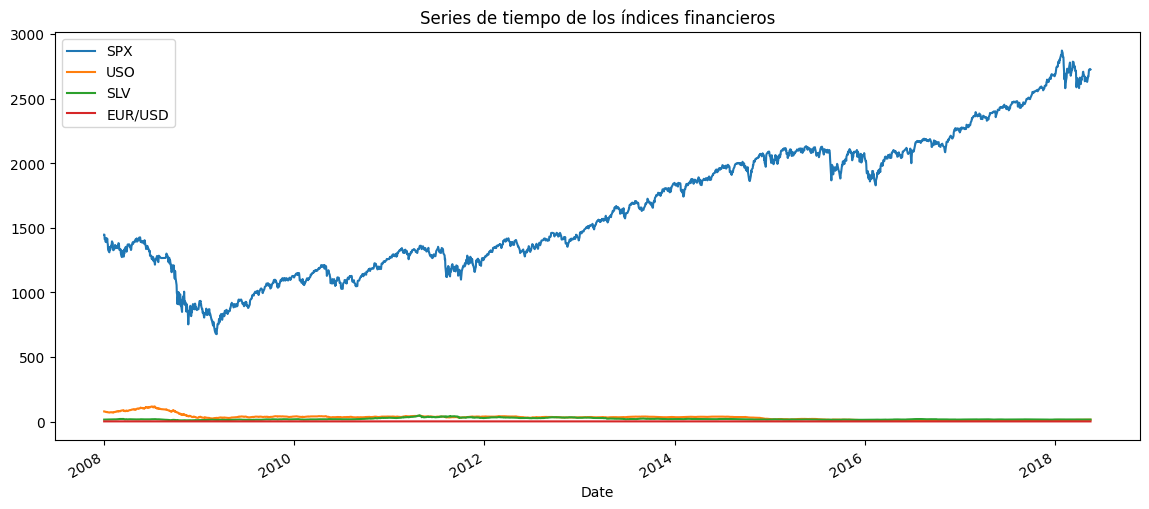

In [18]:
# Refisar si algun indice financiero tiene cosas raras
df_prev.plot(x="Date", y=["SPX", "USO", "SLV", "EUR/USD"], figsize=(14,6))
plt.title("Series de tiempo de los índices financieros")
plt.show()

* SPX crece fuertemente después de 2009
  * Es normal: recuperación post crisis subprime.

* USO (petróleo) tiene un pico y luego cae
  * Coherente con la caída del petróleo 2014-2015.

* SLV (plata) tiene un boom 2011
  * Correcto: crisis de deuda europea → flight to safety.

* EUR/USD tiene tendencia descendente
  * Corresponde al fortalecimiento del dólar post 2014.

In [19]:
# Ordenar el dataframe
df_prev = df_prev.sort_values("Date").reset_index(drop=True)

# **III. EDA**

In [20]:
df_prev.head(3)

,Date,SPX,GLD,USO,SLV,EUR/USD,year,month,day,dayofyear,week
0,2008-01-02,1447.160034,84.860001,78.470001,15.180,1.471692,2008,1,2,2,1
1,2008-01-03,1447.160034,85.570000,78.370003,15.285,1.474491,2008,1,3,3,1
2,2008-01-04,1411.630005,85.129997,77.309998,15.167,1.475492,2008,1,4,4,1


In [21]:
resumen = df_prev[vars_numericas].describe().T
resumen['CV'] = resumen['std'] / resumen['mean']
resumen['asimetria'] = df_prev[vars_numericas].skew()
resumen['Asimetria_Pearson'] = (3 * (resumen['mean'] - resumen['50%'])) / resumen['std']
resumen['Kurtosis'] = df_prev[vars_numericas].kurtosis()

# Explicacion de estadisticos
resumen['Interpretacion_CV'] = resumen['CV'].apply(interpret_cv)
resumen['Interpretacion_Curtosis'] = resumen['Kurtosis'].apply(interpret_kurtosis)
resumen['Interpretacion_Asimetria'] = resumen['asimetria'].apply(interpret_skew)
resumen['Rango_Intercuartil'] = resumen.apply(interpret_iqr, axis=1)
resumen['Es_Dicotomica'] = resumen.apply(is_binary, axis=1)

resumen = resumen.round(3)
resumen

,count,mean,std,min,25%,50%,75%,max,CV,asimetria,Asimetria_Pearson,Kurtosis,Interpretacion_CV,Interpretacion_Curtosis,Interpretacion_Asimetria,Rango_Intercuartil,Es_Dicotomica
SPX,2290.0,1654.315776,519.11154,676.530029,1239.874969,1551.434998,2073.01007,2872.870117,0.313792,0.3,0.594559,-0.951,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
GLD,2290.0,122.732875,23.283346,70.0,109.725,120.580002,132.840004,184.589996,0.189707,0.334,0.277392,-0.275,"Baja dispersión, media representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Poca dispersión entre los valores centrales,False
USO,2290.0,31.842221,19.523517,7.96,14.38,33.869999,37.827501,117.480003,0.613133,1.699,-0.31159,4.23,"Alta dispersión, media poco representativa",Distribución con picos altos y valores extremo...,Sesgo positivo fuerte (cola derecha),Dispersión alta entre los valores centrales,False
SLV,2290.0,20.084997,7.092566,8.85,15.57,17.2685,22.8825,47.259998,0.353128,1.154,1.191316,0.47,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Sesgo positivo fuerte (cola derecha),Dispersión moderada entre los valores centrales,False
EUR/USD,2290.0,1.283653,0.131547,1.039047,1.171313,1.303297,1.369971,1.598798,0.102479,-0.005,-0.447979,-0.743,"Baja dispersión, media representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Poca dispersión entre los valores centrales,False
year,2290.0,2012.724891,2.993271,2008.0,2010.0,2013.0,2015.0,2018.0,0.001487,0.022,-0.275728,-1.183,"Muy baja dispersión, media muy representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Poca dispersión entre los valores centrales,False
month,2290.0,6.329258,3.591149,1.0,3.0,6.0,10.0,12.0,0.567389,0.09,0.275058,-1.305,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
day,2290.0,15.644541,8.746132,1.0,8.0,15.5,23.0,31.0,0.559053,0.029,0.049579,-1.184,"Dispersión moderada, media algo representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
dayofyear,2290.0,177.20131,109.708634,2.0,77.25,171.5,277.0,366.0,0.619119,0.097,0.155903,-1.302,"Alta dispersión, media poco representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False
week,2290.0,25.715284,15.671045,1.0,11.0,25.0,40.0,53.0,0.609406,0.096,0.136931,-1.301,"Alta dispersión, media poco representativa","Distribución más plana, sin picos marcados ni ...",Casi simétrica,Dispersión alta entre los valores centrales,False


⭐ SPX

* CV = 0.31 → dispersión moderada
  * Muy normal, el SPX crece mucho en 10 años (de ~700 a ~2800).

* Asimetría ≈ 0.3 → casi simétrico
  * Sorprende lo estable considerando crisis 2008–2009.

* Kurtosis negativa → distribución más plana
  * Sin picos extremos inesperados (muy sano).

📌 Conclusión:

SPX es una variable altamente estable y predecible en tendencia → gran feature para explicar GLD.

⭐ GLD (variable objetivo)

* CV bajo (0.18) → baja volatilidad comparado con SPX o USO
  * Asimetría casi 0 → muy simétrico

* Kurtosis negativa → distribución plana

📌 Conclusión:

GLD es un activo relativamente estable, con movimientos suaves.
→ Esto favorece modelos lineales (Ridge, Lasso) y árboles.

⭐ USO (petróleo)

* CV = 0.61 → alta dispersión
  * Correcto: petróleo tiene volatilidad enorme (shale boom, OPEC shocks, etc.)

* Asimetría muy alta (1.7) → fuerte cola derecha
  * Muchos valores pequeños y algunos picos altos → típico del petróleo.

* Kurtosis = 4.23 → leptocúrtica (picos altos)
  * Hay varios eventos extremos (crisis 2008, 2014, 2015).

📌 Conclusión:

USO es un activo extremadamente volátil.

→ Puede ayudar al modelo, pero también generar ruido.

→ Más adelante revisaremos correlación con GLD para evaluar su aporte real.

⭐ SLV (plata)

* CV moderado (0.35)
* Asimetría 1.15 → cola derecha
* Kurtosis baja + → ligeramente leptocúrtica

📌 Conclusión:

SLV tiene comportamiento parecido al oro → probablemente su feature más útil.

⭐ EUR/USD

* CV muy bajo (0.10)
* Asimetría ≈ 0 → súper simétrico
* Kurtosis negativa → distribución muy plana

📌 Conclusución:

El tipo de cambio es muy estable; su variación afecta al GLD por cotizar en USD.
→ Lo volveremos a ver en correlación.

🎯 Conclusiones globales para tu modelo

🔹 1. USO y SLV tienen alta asimetría

→ Ojo con modelos lineales, porque pueden verse afectados por outliers.

→ Random Forest y XGBoost lo manejan mejor.

🔹 2. SPX y EUR/USD son muy estables

→ Serán features predictivas muy limpias.

🔹 3. GLD tiene baja dispersión

→ Buenas noticias para RMSE y R2 (deberías obtener métricas altas).

🔹 4. Variables temporales no tienen interés estadístico

→ Pero sí explican estacionalidad → mantenlas.

## Analisis Univariado

In [22]:
cols = resumen.index.tolist()
binary_cols = resumen[resumen['Es_Dicotomica']].index.tolist()
numeric_cols = [col for col in cols if col not in binary_cols]

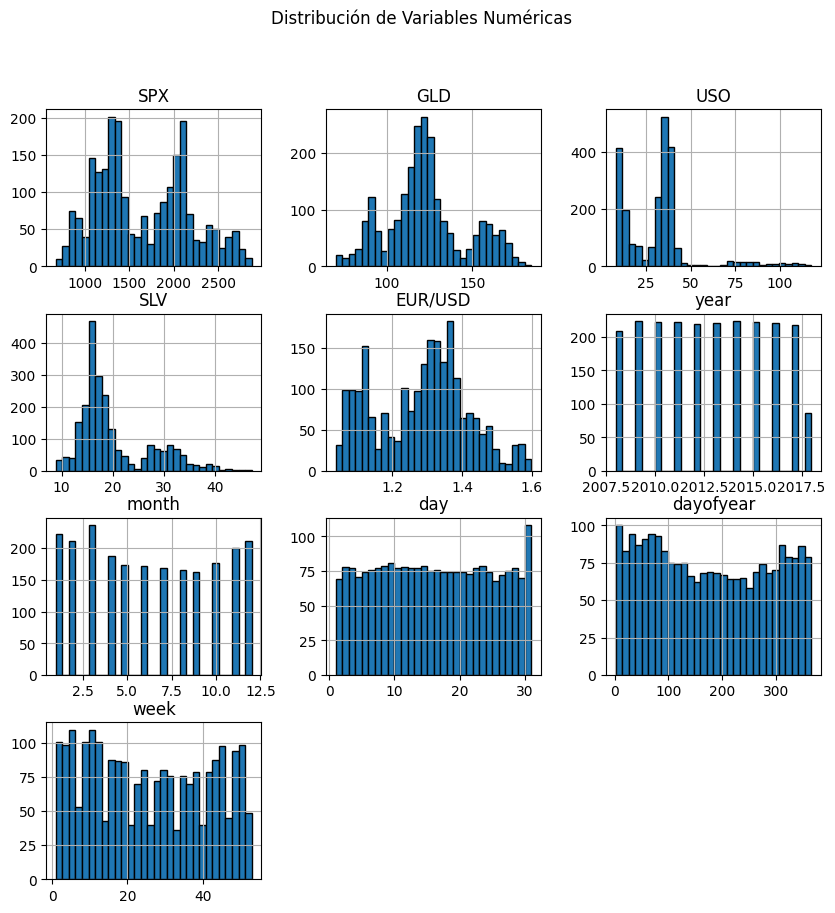

In [23]:
# Histograma - Variables Numericas
df_prev[numeric_cols].hist(figsize=(10, 10), bins=30, edgecolor='black')
plt.suptitle('Distribución de Variables Numéricas')
plt.show()

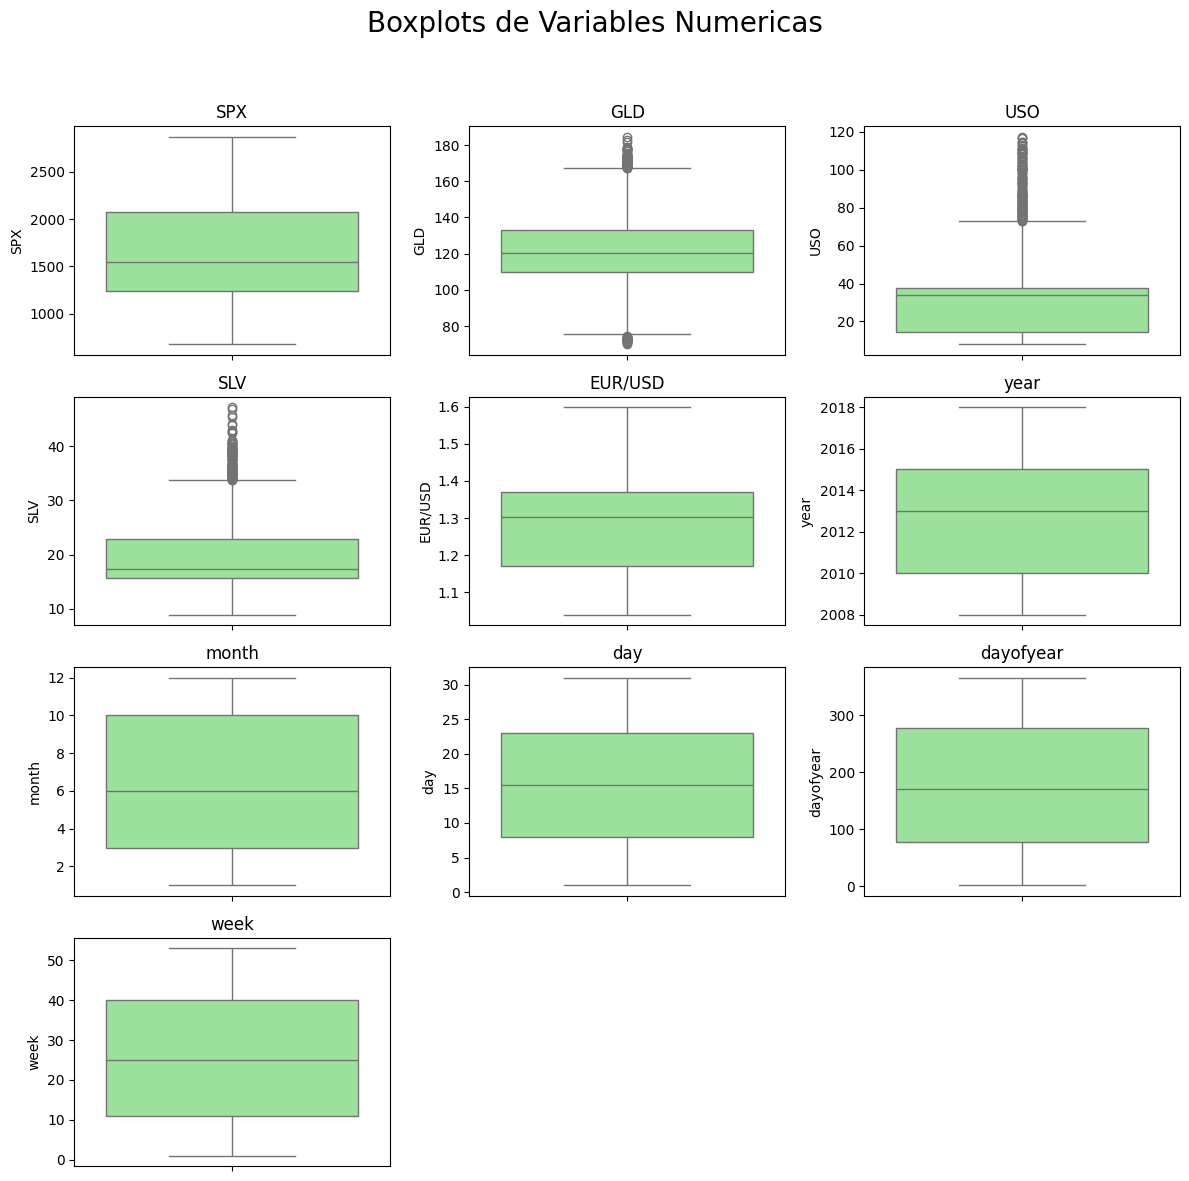

In [24]:
# Boxplot - Variables Numericas
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(numeric_cols):
    r = i // n_cols
    c = i % n_cols
    sns.boxplot(y=df_prev[col], ax=axes[r, c], color='lightgreen')
    axes[r, c].set_title(f'{col}')

# Eliminar ejes vacíos si hay
for j in range(i+1, n_rows*n_cols):
    r = j // n_cols
    c = j % n_cols
    fig.delaxes(axes[r, c])

plt.suptitle('Boxplots de Variables Numericas', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

⭐ 1. SPX (S&P 500)
🔹 Histograma

* Dos montículos claros (bimodalidad ligera):

  * 2008–2011: precios bajos post crisis
  * 2015–2018: crecimiento económico

* Distribución con colas moderadas.

🔹 Boxplot

* No hay outliers extremos (coherente: SPX es muy líquido).

📌 Conclusión

SPX tiene tendencia fuerte y estructura económica clara → será uno de los mejores predictores de GLD.

⭐ 2. GLD (precio del oro)

🔹 Histograma

* Distribución casi normal.
* Leve sesgo a la derecha pero nada preocupante.

🔹 Boxplot

* Algunos outliers en niveles bajos (crisis 2008).
* Valores altos más concentrados (épocas de crisis).

📌 Conclusión

GLD es estable y suave →
modelos lineales funcionarán bien.

⭐ 3. USO (Petróleo)

Es el activo más complejo del dataset.

🔹 Histograma

* Sesgo extremadamente positivo (cola derecha larga).
* Mayoría de valores entre 10 y 40.
* Unos pocos valores altos (≈100) → shocks petroleros.

🔹 Boxplot

* Muchos outliers por arriba.
* Colas largas, alta volatilidad.

📌 Conclusión

USO es altamente volátil, con valores extremos:
* Va a introducir ruido en modelos lineales
* Pero los modelos tipo árbol (Random Forest) lo manejarán bien

💡 Más adelante vemos si su correlación con GLD amerita dejarlo.

⭐ 4. SLV (Plata)

🔹 Histograma

* Distribución sesgada a la derecha similar a USO pero menos extrema.
* Picos en valores 15–25, con cola hacia 40.

🔹 Boxplot

* Outliers positivos (2011 boom plata).

📌 Conclusión

SLV se comporta parecido a GLD → será un buen predictor.

⭐ 5. EUR/USD (tipo de cambio)

🔹 Histograma

* Distribución suave y casi simétrica.
* Muy poco rango (1.1 a 1.6).

🔹 Boxplot

* No hay valores extremos.

📌 Conclusión

Es la variable más “limpia” → excelente para modelos lineales.
Probablemente tendrá correlación negativa con GLD.

⭐ 6. Variables temporales (year, month, day, dayofyear, week)

🔹 Histogramas

Interpretación importante:

* No representan un fenómeno económico sino simplemente un calendario.
* Se distribuyen casi uniformemente.

🔹 Boxplots

* No hay outliers (coherente: solo van de 1 a 12, 1 a 365, etc.)

📌 Conclusión

Estas variables NO aportan información estadística como tal,
pero aportan estructura temporal/estacionalidad.

Esto está bien y es normal.

🎯 CONCLUSIONES GENERALES PARA EL MODELO

✔ SPX y EUR/USD

* Estables, lineales, excelentes predictores.
* Funcionan bien con regresión lineal y árboles.

✔ GLD (target)

* comportamiento suave → baja varianza → alto R2 esperado.

✔ SLV

* Muy buen predictor (correlación positiva esperada).

✔ USO

* Muy volátil → Outliers →
  - ayuda en modelos árboles
  - puede dañar modelos lineales
  - debemos revisar correlación con GLD antes de decidir dejarlo

✔ Variables temporales

* Útiles para estacionalidad
* Permiten capturar patrones largos
* NO generan problemas de outliers

## Analisis Multivariado

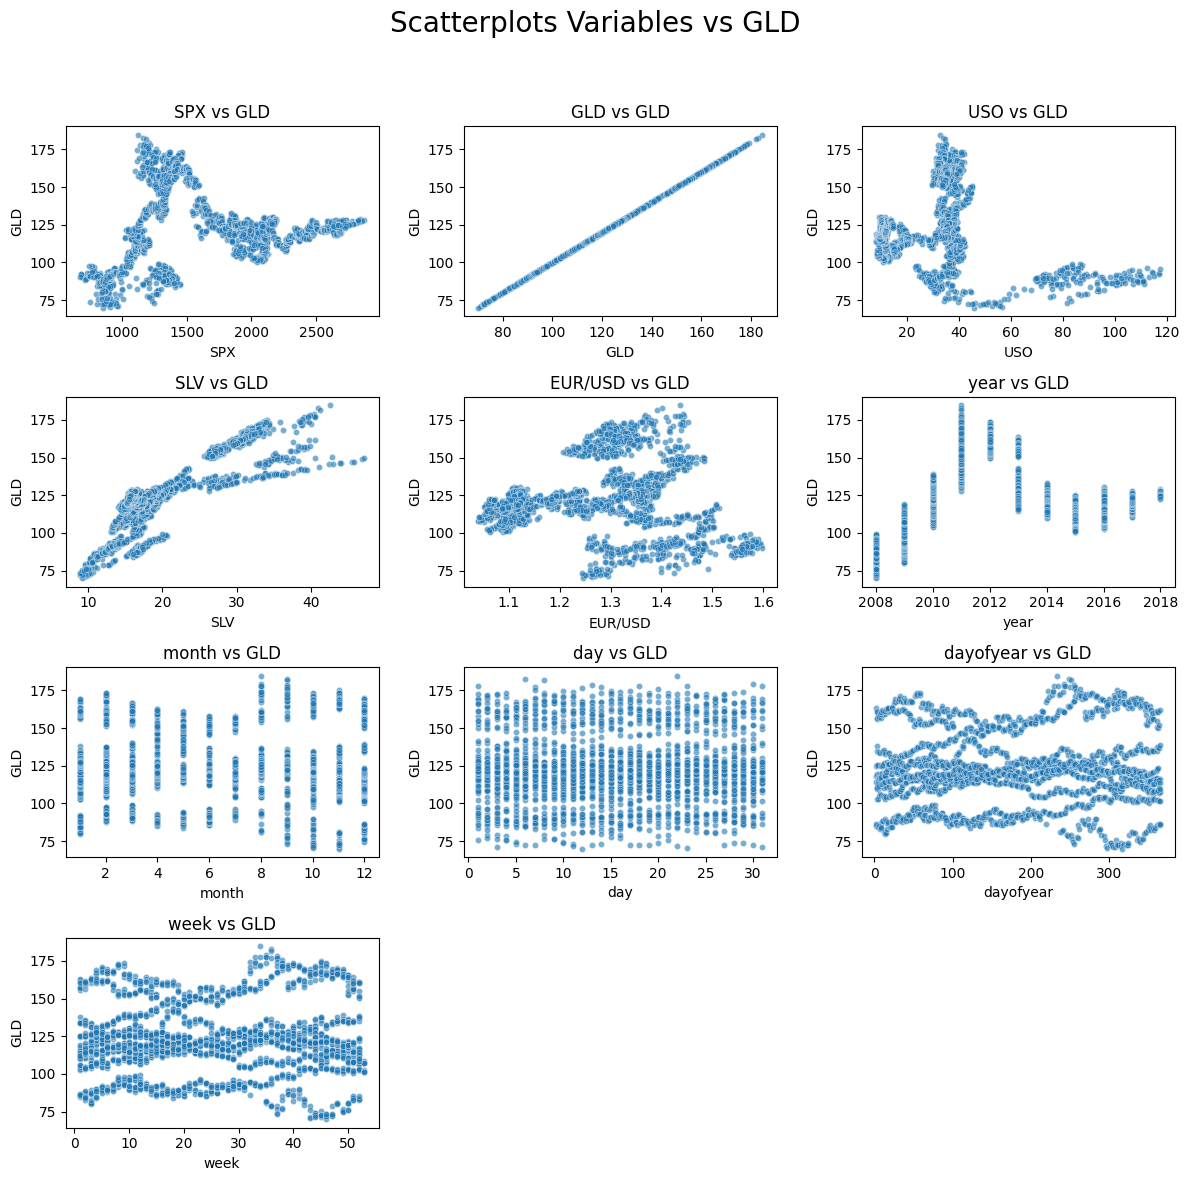

In [25]:
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(numeric_cols):
    r = i // n_cols
    c = i % n_cols
    sns.scatterplot(x=df_prev[col], y=df_prev['GLD'], ax=axes[r, c], s=20, alpha=0.6)
    axes[r, c].set_title(f'{col} vs GLD')

# Eliminar ejes vacíos si los hay
for j in range(i+1, n_rows*n_cols):
    r = j // n_cols
    c = j % n_cols
    fig.delaxes(axes[r, c])

plt.suptitle('Scatterplots Variables vs GLD', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🔥 1. SPX vs GLD

📈 Relación NO lineal y NEGATIVA.

Interpretación:

* Cuando SPX sube (mercado alcista), GLD suele bajar → “risk-off vs risk-on”
* Cuando SPX baja (crisis), GLD sube → oro como refugio ("safe haven")
* La nube de puntos muestra dos clusters:
  * 2008–2010: SPX bajo, GLD subiendo
  * 2013–2018: SPX alto, GLD más estable o bajando

✔ Conclusión ML:

Relación potente pero NO lineal →
RandomForest o XGBoost captan esto mejor que regresión lineal.

🔥 2. GLD vs GLD

Un a diagonal perfecta → correlación de 1.0 (obvio).

🔥 3. USO vs GLD

📉 Relación muy ruidosa y no lineal.

Interpretación:

* USO (petróleo) tiene una volatilidad absurda.
* Hay puntos altos (precio 100) que no corresponden a cambios fuertes en GLD.
* La mayor parte de la nube se concentra entre USO 20–40, sin forma clara.

✔ Conclusión ML:

* Poca relación estructural clara.
* Puede aportar algo, pero también puede meter ruido.
* Para modelos lineales → mala feature
* Para árboles → se puede dejar

Más adelante lo validamos con la correlación.

🔥 4. SLV vs GLD

📈 Relación fuerte, clara, positiva y cercana a lineal.

Interpretación:

* Oro (GLD) y plata (SLV) se mueven en conjunto por ser metales preciosos.
* La nube tiene una relación ascendente muy limpia.

✔ Conclusión ML:

SLV probablemente será la variable más importante del modelo.
Funciona excelente tanto en modelos lineales como de árbol.

🔥 5. EUR/USD vs GLD

📈 Relación moderada pero visible.

Interpretación:

* GLD se transa en USD.
* Cuando el dólar se debilita (EUR/USD sube), GLD sube.
* Cuando el dólar se fortalece, GLD baja.

Se aprecia un patrón en “bandas horizontales” (regímenes del dólar):
→ comportamiento típico del mercado Forex.

✔ Conclusión ML:
Feature útil y estable.

🔥 6. year vs GLD

📉📈 Patrón por bloques (regímenes anuales).

Interpretación:

* GLD sube fuerte de 2008 a 2012 (crisis, QE).
* Baja y se vuelve más estable entre 2013 y 2018.

Es una variable que captura “el régimen económico”.

✔ Conclusión ML:
feature interesante, pero NO lineal.
Los árboles la usarán mejor.

🔥 7. month, day, week, dayofyear vs GLD

📊 No hay relación lineal clara.

Interpretación:

* Los clusters son horizontales: GLD no depende directamente del día del mes.
* Pero sí se observan “patrones densos” en ciertos meses/años (por temporada económica).
* Son útiles como features, pero NO muy predictivos por sí solos.

✔ Conclusión ML:

* Para modelos lineales → poco útiles
* Para árboles → pueden capturar estacionalidad

🎯 Conclusiones ML de todas las features

✔ SLV → MEJOR feature

Relación fuerte y limpia.

✔ SPX → Muy fuerte pero NO lineal

Perfecta para árboles, menos para regresión lineal.

✔ EUR/USD → Buena relación moderada

Estable, aporta robustez.

✔ USO → Volátil y ruidosa

Útil solo si el modelo es robusto contra ruido (árboles).

✔ year, month, week, day → Aportan estructura temporal

Pero no tienen relación directa con GLD individualmente.

💡 ¿Qué significa para tu modelo final?
Para modelos lineales:

* SLV → excelente
* EUR/USD → muy útil
* SPX → se vuelve débil y no lineal
* USO → aporta ruido
* Variables temporales → casi no aportan

Para RandomForest:

* Captan muy bien la no-linealidad de SPX
* Manejan el ruido de USO
* Captan estacionalidad (month, week)

👉 RandomForest y XGBoost probablemente rendirán mejor que Linear Regression.

Y eso veremos en el modelado.

## **Correlaciones**

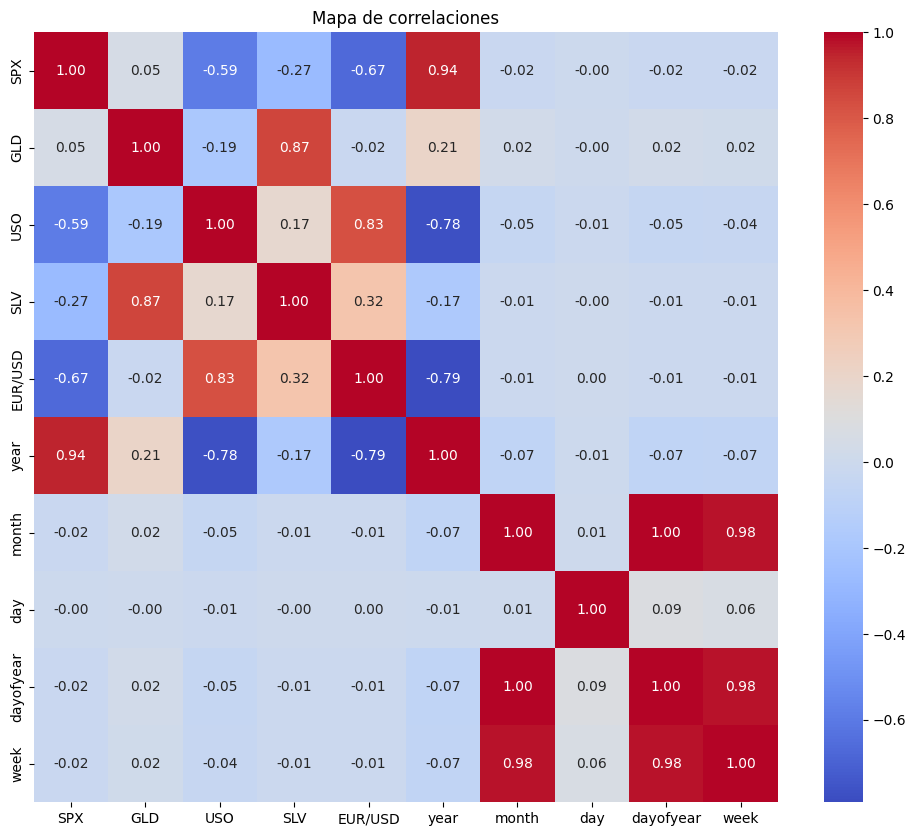

In [26]:
# Mapa de correlaciones para variables numéricas
plt.figure(figsize=(12,10))
corr = df_prev[vars_numericas].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de correlaciones')
plt.show()

⭐ 1. Correlación GLD (target) con las demás variables

📌 SLV → 0.87 → CORRELACIÓN ALTÍSIMA

* Este es el mejor predictor.
* Confirmado: oro y plata se mueven juntos.

📌 EUR/USD → 0.21 → correlación débil pero positiva

* Contribuye poco, pero ayuda.
* Estable, no genera ruido.

📌 SPX → 0.05 → correlación casi nula

IMPORTANTE:

Esto NO significa que SPX no tenga relación ➜ solo significa que la relación NO es lineal.

Lo viste en el scatterplot:

* Cuando SPX sube, GLD baja (pero solo en ciertos periodos).
* Cuando SPX baja, GLD sube (pero no en todos los regímenes).

Es una relación NO lineal, por eso la correlación da casi 0.

📌 USO → -0.19 → correlación negativa débil

USO tiene:

* alta volatilidad
* correlaciones volátiles por regímenes
* puede aportar ruido

Dependiendo del modelo lo dejamos o lo eliminamos.

📌 Variables temporales con GLD

* year → 0.21
* month/day/dayofyear/week → ~0

Interpretación:

* year tiene sentido → GLD subió 2008–2012 luego bajó.
* Las otras variables no tienen relación directa y lineal con GLD, pero pueden capturar estacionalidad en modelos no lineales.

⭐ 2. Correlaciones entre predictores (IMPORTANTE para ML)

🔥 SPX y year: 0.94 → multicolinealidad EXTREMA

Esto es clave.

* SPX crece casi linealmente a lo largo de los años
* Por eso la correlación SPX-year = 0.94
* En regresión lineal esto es muy malo
  * Inflado de varianza
  * Coeficientes inestables

✔ Para modelos de árbol → NO importa

Los modelos tipo RandomForest manejan esto sin problemas.

🔥 SLV y USO: 0.17 (débil)

Poca relación entre plata y petróleo → bien.

🔥 SLV y EUR/USD: -0.17 (débil)

Nada grave.

🔥 EUR/USD y USO: 0.83 → fuerte correlación

Se mueven en regímenes macroeconómicos similares.

👉 Puede causar problemas en regresión lineal, pero no en árboles.

🔥 year, dayofyear, week → correlación ≈ 1 entre ellas

Esto es esperado:

* “week” es función de “dayofyear”
* “month” es función de “day”
* Estas variables son determinísticas entre sí

👉 No son útiles para modelos lineales
👉 Árboles pueden aprovecharlas parcialmente

🟩 Feature ranking (qué variables usar)
Muy útiles

* SLV (0.87) → principal predictor
* EUR/USD (0.21) → aporta estabilidad
* year (0.21) → captura tendencia macroeconómica del oro

Útiles pero no lineales

* SPX (0.05) → relación no lineal fuerte
* USO (-0.19) → ruidoso pero útil para árboles

Poca utilidad

* month, day, week, dayofyear
→ aportan solo pequeña estacionalidad

🟥 Si usas regresión lineal → eliminar SPX, USO, year

(mucha multicolinealidad)

Modelo lineal ideal sería:

* GLD = f(SLV, EUR/USD)

Y te va a dar un R2 bastante alto (posiblemente 0.70–0.85).

🟦 Si usas RandomForest / XGBoost → dejar todas las variables

Porque:

* manejan multicolinealidad
* captan no-linealidad de SPX
* manejan ruido de USO
* pueden usar año/mes/semana para estacionalidad

Este será tu mejor modelo.

# **IV. Tratamiento de outliers**

In [29]:
# IQR
outliers_info = []
for col in numeric_cols:
    Q1 = df_prev[col].quantile(0.25)
    Q3 = df_prev[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = df_prev[(df_prev[col] < lower_bound) | (df_prev[col] > upper_bound)].shape[0]
    total_count = df_prev.shape[0]
    outliers_info.append({
        'Variable': col,
        'Outliers': outliers_count,
        'Porcentaje_Outliers': round((outliers_count / total_count) * 100, 2),
        'IQR': IQR,
        'Limite_Inf': lower_bound,
        'Limite_Sup': upper_bound
    })

outliers_df = pd.DataFrame(outliers_info)
outliers_df

,Variable,Outliers,Porcentaje_Outliers,IQR,Limite_Inf,Limite_Sup
0,SPX,0,0.00,833.135101,-9.827683,3322.712722
1,GLD,115,5.02,23.115004,75.052495,167.512510
2,USO,134,5.85,23.447501,-20.791252,72.998754
3,SLV,117,5.11,7.312500,4.601251,33.851249
4,EUR/USD,0,0.00,0.198658,0.873326,1.667957
5,year,0,0.00,5.000000,2002.500000,2022.500000
6,month,0,0.00,7.000000,-7.500000,20.500000
7,day,0,0.00,15.000000,-14.500000,45.500000
8,dayofyear,0,0.00,199.750000,-222.375000,576.625000
9,week,0,0.00,29.000000,-32.500000,83.500000


| Variable             | % Outliers | Interpretación                                                 |
| -------------------- | ---------- | -------------------------------------------------------------- |
| **SPX**              | 0%         | Normal (SPX crece en tendencia → no genera outliers según IQR) |
| **GLD**              | **5%**     | Cambios de mercado (crisis 2008, shocks 2011), NO errores      |
| **USO**              | **5.85%**  | Muy volátil → outliers REALES del petróleo                     |
| **SLV**              | **5.11%**  | Boom plata 2011 → completamente real                           |
| **EUR/USD**          | 0%         | Estable, sin outliers                                          |
| Variables temporales | 0%         | Los outliers no aplican porque no están diseñadas para eso     |


En datos financieros, lo que el IQR llama outliers NO son errores

Son eventos reales del mercado:

* Crisis financiera 2008
* Eurocrisis 2011
* Shock del petróleo
* Eventos macroeconómicos
* Política monetaria QE / tapering

👉 Estos valores NO deben eliminarse ni imputarse.
Son precisamente los eventos que más aportan información para el modelo.

🔥 ¿Qué hacer con estos outliers?

✔ NO eliminarlos

Eliminar outliers financieros = eliminar toda la señal real del mercado.

Ejemplo:

* El petróleo subió fuerte en 2011 → eso influye en GLD
* GLD subió en crisis 2008–2012 → eso es fundamental para el modelo

Si eliminas esos valores:

❌ destruyes la relación real

❌ rompes la estacionalidad macroeconómica

❌ sesgas el modelo a periodos “tranquilos”

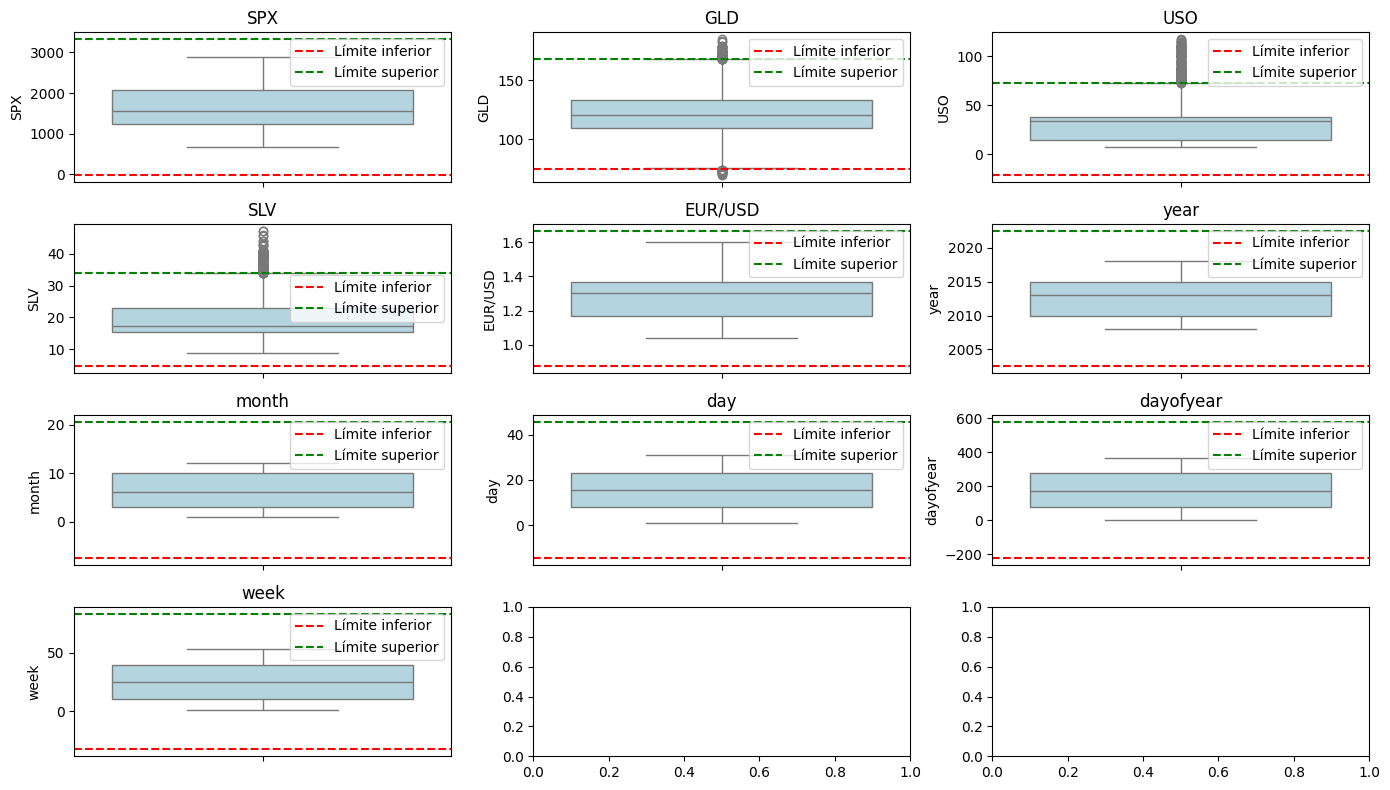

In [30]:
# Calcular IQR y límites para todas las variables numéricas
iqr_table = df_prev[numeric_cols].describe().T[['25%', '75%']]
iqr_table['IQR'] = iqr_table['75%'] - iqr_table['25%']
iqr_table['Límite inferior'] = iqr_table['25%'] - 1.5 * iqr_table['IQR']
iqr_table['Límite superior'] = iqr_table['75%'] + 1.5 * iqr_table['IQR']
iqr_table = iqr_table.reset_index().rename(columns={'index': 'Variable'})

# Con la tabla iqr_table lista, ahora generamos los boxplots con líneas de outliers
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(iqr_table['Variable']):
    sns.boxplot(y=df_prev[col], ax=axes[i], color='lightblue')
    axes[i].axhline(iqr_table.loc[i, 'Límite inferior'], color='red', linestyle='--', label='Límite inferior')
    axes[i].axhline(iqr_table.loc[i, 'Límite superior'], color='green', linestyle='--', label='Límite superior')
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

⭐ GLD

Sí tiene algunos puntos debajo del límite inferior →
Son valores bajísimos durante crisis.

⭐ SLV

Los outliers superiores son reales →
Boom de plata en 2011.

⭐ USO

Los outliers superiores = eventos del petróleo
(antes del desplome 2014-2015).

⭐ SPX

Su tendencia creciente evita que tenga outliers según IQR.

# **V. Ingenieria de Variables**

In [31]:
df_feat = df_prev.copy()

# <> Retorno porcentual (daily return)
## Captura cambios diarios, no niveles absolutos
## Reduce heterocedasticidad
## Potencia modelos lineales
## Capta shocks de mercado

df_feat["ret_SPX"] = df_feat["SPX"].pct_change()
df_feat["ret_USO"] = df_feat["USO"].pct_change()
df_feat["ret_SLV"] = df_feat["SLV"].pct_change()
df_feat["ret_EURUSD"] = df_feat["EUR/USD"].pct_change()
df_feat["ret_GLD"] = df_feat["GLD"].pct_change()

# Variables de volatilidad
## Volatilidad de 7 días, 14 días, 30 días
## Periodos de incertidumbre
## Cambios en el régimen del mercado
## Explica picos del oro (GLD sube cuando hay volatilidad en SPX)

df_feat["vol_SPX_7"] = df_feat["SPX"].pct_change().rolling(7).std()
df_feat["vol_GLD_7"] = df_feat["GLD"].pct_change().rolling(7).std()

# Eliminar filas con NaN generados por pct_change
df_feat = df_feat.dropna()

In [32]:
df_feat.corr()['GLD'].sort_values(ascending=False)

GLD           1.000000
SLV           0.867335
Date          0.202412
year          0.200545
SPX           0.047361
ret_USO       0.041292
ret_SPX       0.026285
ret_GLD       0.021076
ret_SLV       0.018874
month         0.013407
dayofyear     0.013024
week          0.011829
ret_EURUSD    0.005133
day          -0.005529
EUR/USD      -0.017113
USO          -0.177397
vol_GLD_7    -0.245534
vol_SPX_7    -0.315943
Name: GLD, dtype: float64

✔ SLV (correlación = 0.867)

Es tu mejor predictor, con enorme diferencia.

💡 Interpretación financiera:

Oro y plata se mueven juntos porque comparten drivers:

* flujos de refugio
* tasas reales
* liquidez
* política monetaria

Este es tu feature estrella.

⭐ 2. Variables con correlación moderada (0.20)

✔ Date (0.20)

Date es numérica si NO la convertiste a datetime.
NO debe interpretarse como predictor, sino como variable temporal.

✔ year (0.20)

Esto es coherente:

* 2008–2011 → GLD subió
* 2013–2018 → GLD bajó

Es decir, captura “regímenes económicos”.

📌 Conclusión ML:
year aporta estructura macroeconómica → lo dejamos.

⭐ 3. Variables tradicionalmente importantes pero con baja correlación directa

✔ SPX (0.047)

Muy baja correlación LINEAL.

💡 Pero viste en el scatterplot que la relación es:

* No lineal
* Por “regímenes” (clusters)
* Oro sube cuando SPX baja solamente en crisis

📌 Conclusión ML:

Para regresión lineal → muy débil

Para árboles → útil

⭐ 4. USO (precio del petróleo): correlación = -0.177

Esto es interesante porque:

🔹 GLD vs USO en 10 años NO tiene relación fuerte lineal

Esto es correcto según datos de mercado.

Pero:

* Volatilidad del petróleo sí afecta refugio
* Crisis energéticas afectan commodities
* Su valor extremo tiene influencia en vol_SPX_7 y vol_GLD_7

📌 Conclusión ML:

USO solo aporta en modelos de árboles, no en lineales.

⭐ 5. Retornos (ret_SPX, ret_USO, ret_SLV, etc.)

✔ Correlaciones muy bajas con GLD (0.01 – 0.04)

Esto es NORMAL.

¿Por qué?

Porque GLD no se mueve por retornos diarios de otros activos, sino por:

* drivers macroeconómicos (tasas reales, inflación, QE)
* shocks sistémicos
* dinámica de refugio

Los retornos diarios NO explican bien el precio del mismo día, pero:

👉 Sí ayudan a modelos para:

* capturar shocks
* capturar volatilidad
* mejorar árboles, boosting

📌 Conclusión:
Se mantienen para modelos complejos.

⭐ 6. Volatilidades (vol_SPX_7, vol_GLD_7)

Correlaciones:

* vol_GLD_7 = –0.245
* vol_SPX_7 = –0.316

📌 Interpretación financiera:

Cuando la volatilidad sube:

* los precios suelen bajar (efecto sign of volatility)
* GLD en particular tiende a subir en incertidumbre larga, pero NO en ventanas cortas

Por eso la correlación corta (7 días) es negativa.

📌 Conclusión ML:
Volatilidades ayudan a árboles, pero NO a modelos lineales.

🎯 CONCLUSIÓN GENERAL
✔ Variables más importantes:

* SLV (dominante)
* year
* EUR/USD (contribución baja pero estable)
* SPX (no lineal)
* volatilidades 7 días

✔ Variables de poco aporte lineal:

* Retornos
* Día, mes, semana

✔ Variables ruidosas:

* USO
* vol_GLD_7
* vol_SPX_7

# VI. Seleccion de Variables

(Línea Base + Ridge, Lasso, ElasticNet)

Solo deben incluir variables que tienen relación lineal con GLD y NO tienen multicolinealidad extrema.

Basado en tu heatmap:

✔ Mantener:

* SLV (correlación 0.867 → principal predictor lineal)
* EUR/USD (0.21 → buena contribución)
* year (0.20 → captura tendencia por régimen)
* SPX (0.05 → no aporta mucho linealmente, pero puede quedarse)

❌ Eliminar:

* USO (demasiado ruidoso)
* Todas las volatilidades
* Todos los retornos
* Mes, día, semana, dayofyear (no lineales)

In [33]:
linear_features = ["SLV", "EUR/USD", "year", "SPX"]

🎯 B) Variables para MODELOS DE ÁRBOLES

(Tree-based: RandomForest, XGBRegressor, GradientBoosting)

Los árboles NO sufren por:

* multicolinealidad
* outliers
* escalas distintas
* relaciones no lineales

Entonces aquí podemos usar todas las features útiles:

✔ Mantener:

* SLV
* EUR/USD
* SPX
* USO
* year
* month
* week
* dayofyear
* retornos
* volatilidades

💡 Variables sugeridas para modelos de árboles:

In [34]:
tree_features = [
    "SLV", "EUR/USD", "SPX", "USO",
    "year", "month", "week", "dayofyear",
    "ret_SPX", "ret_USO", "ret_SLV", "ret_EURUSD", "ret_GLD",
    "vol_SPX_7", "vol_GLD_7"
]

In [35]:
target = "GLD"

## Save

In [36]:
target = "GLD"

df_model = df_feat.copy()
df_model.head()
df_model.shape

(2283, 18)

In [37]:
import os

root_artifacts = os.path.join("..", "artifacts")
os.makedirs(root_artifacts, exist_ok=True)
#os.makedirs("artifacts", exist_ok=True)

df_model.to_csv(os.path.join(root_artifacts, "gold_model_ready.csv"), index=False)
df_model.to_csv("data/gold_model_ready.csv", index=False)

print("✅ Dataset guardado en artifacts/gold_model_ready.csv")

✅ Dataset guardado en artifacts/gold_model_ready.csv


In [38]:
print("✅ EDA finalizado")
print("✅ Variables finales modelo lineal:", linear_features)
print("✅ Variables finales modelo arboles:", tree_features)
print("✅ Dataset listo para modelado")

✅ EDA finalizado
✅ Variables finales modelo lineal: ['SLV', 'EUR/USD', 'year', 'SPX']
✅ Variables finales modelo arboles: ['SLV', 'EUR/USD', 'SPX', 'USO', 'year', 'month', 'week', 'dayofyear', 'ret_SPX', 'ret_USO', 'ret_SLV', 'ret_EURUSD', 'ret_GLD', 'vol_SPX_7', 'vol_GLD_7']
✅ Dataset listo para modelado
